# Classifying Humorous Text from Yelp Reviews

In [44]:
# !!! Note for Group: takes my machine about 40 min before split train/test sets.
# You may want to run it on Colab or download https://drive.google.com/file/d/11WdZeVN-hc-HmODwFiNHgeZse_v3yxNH/view?usp=sharing 
# for csv of approx 840k+ texts ('review') with labels ('humor') instead.

In [63]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from etl_humor import *

In [41]:
# specify device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load & Clean Data

##### Download dataset from https://www.kaggle.com/yelp-dataset/yelp-dataset

In [32]:
review_df = df_from_json("./data/yelp_academic_dataset_review.json")
business_df = df_from_json("./data/yelp_academic_dataset_business.json")

In [33]:
# Clean review text and add word count column to review df
review_df = review_df[['user_id', 'business_id', 'stars', 'useful', 'funny','text']]
review_df['text'] = review_df['text'].apply(format_review)
review_df['word_count'] = review_df['text'].apply(word_count)

In [34]:
# Select columns in business df and rename stars to avg_stars for business stars
business_df = business_df[['business_id', 'name', 'city', 'state', 'stars', 'review_count', 'is_open', 'attributes', 'categories']]
business_df.columns = ['business_id', 'name', 'city', 'state', 'avg_stars', 'review_count','is_open', 'attributes','categories']
business_df = business_df[business_df['name'].notna()]

In [35]:
# merge reviews with business df to get name, etc.
merged_data_large = pd.merge(business_df, review_df, on="business_id", how = "left")

In [36]:
# Concatenate the name of the business and the text together (some humor is based on the business name)
merged_data_large['review'] = merged_data_large.name + '. ' + merged_data_large.text

In [37]:
# Select columns for final df
final_df_large = merged_data_large[['business_id', 'categories', 'user_id', 'funny', 'review', 'word_count']]

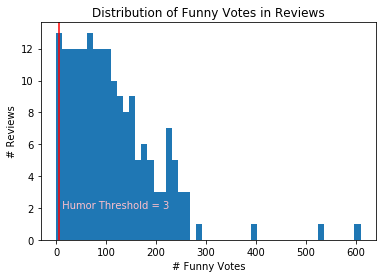

In [38]:
# We will consider a review as humorous if it has 3 or more funny votes and not humorous if it has 0 funny votes. 
# Plot distribution of funny votes.

humor_threshold = 3

humor_pt = final_df_large.pivot_table('user_id', ['funny'], aggfunc='count').reset_index()
funny_votes = humor_pt.funny.values

plt.hist(funny_votes, bins=50, density = False)  # density=False would make counts
plt.axvline(x=5, color = 'red')
plt.text(5, 2, ' Humor Threshold = 3', color = 'pink')
plt.ylabel('# Reviews')
plt.xlabel('# Funny Votes')
plt.title('Distribution of Funny Votes in Reviews')
plt.show()

In [39]:
# Determine how many text we have considered not humorous, humorous, and those that dont make the humor threshold
def f(row):
    if row['funny'] >= humor_threshold:
        val = 1
    elif row['funny'] == 0:
        val = 0
    else:
        val = 'NaN'
    return val

final_df_large['humor'] = final_df_large.apply(f, axis=1)

final_df_large = final_df_large[final_df_large['humor'].notna()]
final_df_large = final_df_large[final_df_large['review'].notna()]

humor_label_pt = final_df_large.pivot_table('review', ['humor'], aggfunc='count').reset_index()
print(humor_label_pt)

/opt/anaconda3/envs/USGS_1/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


  humor   review
0     0  7038968
1     1   340864
2   NaN  1255571


In [40]:
# Select all humorous and 500k not humorous (plain) texts to create more balanced train/test sets.
plain_text = final_df_large[final_df_large.humor == 0]
plain_text = plain_text.sample(n = 500000)
humor_text = final_df_large[final_df_large.humor == 1]

In [41]:
result = pd.concat([plain_text, humor_text])

In [1]:
result.to_csv("./data/yelp_humor_merged.csv", index=False)

NameError: name 'result' is not defined

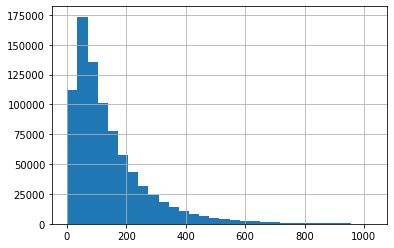

In [25]:
# word count distribution for results
pd.Series(result.word_count.values).hist(bins = 30)

## Split into Training and Testing Sets

#####  !!! Uncomment and run from here if you already have the csv saved.


In [64]:
result = pd.read_csv("./data/yelp_humor_merged.csv")
result.shape

(840864, 7)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(result.review, 
            result.humor, test_size=0.2, random_state=0, stratify=result.humor)

## Import Model and Tokenizer

In [66]:
from transformers import AutoModel, BertTokenizerFast

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

MODEL_TYPE = 'bert-base-uncased'

tokenizer = BertTokenizerFast.from_pretrained(MODEL_TYPE)

## Tokenization

In [67]:
# Rest of the notebook is adapted from 
# https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb

In [ ]:
# max_seq_len = 100

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
#     max_length = max_seq_len,
#     add_special_tokens = True
    padding=True,# or "max_length"?
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
#     max_length = max_seq_len,
#     add_special_tokens = True
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

## Convert to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

## Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

## Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)

## Get Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(y_train), y_train)

print(class_wts)

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

## Fine-tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Train Model

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

## Load Model 

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

## Test Model

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

In [ ]:
# # taking the raw outputs of the stacked encoders of BERT, and attaching their own specific model to it, most commonly 
# # a linear layer, and then fine-tuning this model on their specific dataset

# from transformers import BertModel

# class Bert_Model(nn.Module):
#    def __init__(self, class):
#        super(Bert_Model, self).__init__()
#        self.bert = BertModel.from_pretrained('bert-base-uncased')
#        self.out = nn.Linear(self.bert.config.hidden_size, classes)
#        self.sigmoid = nn.Sigmoid()
#    def forward(self, input):
#        _, output = self.bert(**input)
#        out = self.out(output)
#        return out